## Practice = caltech101

Coding in a long time... I didnt code for 40 days.

lets get init

In [247]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [248]:
##Hardware
import torch
if torch.cuda.is_available() == True:
    device = 'cuda'
    templist = [1,2,3]
    templist = torch.FloatTensor(templist).to(device)
    print("Cuda torch working : ",end="")
    print(templist.is_cuda)
    print("current device no. : ",end="")
    print(torch.cuda.current_device())
    print("GPU device count : ",end="")
    print(torch.cuda.device_count())
    print("GPU name : ",end="")
    print(torch.cuda.get_device_name(0))
    print("device : ",device)
    ! nvidia-smi
elif torch.backends.mps.is_available() == True:
    print("Apple device detected\nActivating Apple Silicon GPU")
    device = torch.device("mps")
else:
    print("cant use gpu , activating cpu")
    device = 'cpu'

Apple device detected
Activating Apple Silicon GPU


### Mannual SEED (for sable test)

In [249]:
'''SEED Everything'''
import random
import numpy as np
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True # keep True if all the input have same size.
SEED=42
seed_everything(SEED=SEED)

## Get Data

In [250]:
from torchvision.datasets import Caltech101
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
import os


#Remove .DS_Store (no need)
ds_store_file = os.path.join('./data/caltech101/101_ObjectCategories', '.DS_Store')
if os.path.exists(ds_store_file):
    os.remove(ds_store_file)

NUM_STREAM = 2 ###CHANGE (REDUCE) VALUE IF ERROR###

#Change Grayscale Image to RGB for the shape
class GrayscaleToRGB(object):
    def __call__(self, img):
        if img.mode == 'L':
            img = img.convert("RGB")
        return img

transform = transforms.Compose(
    [transforms.Resize((224, 224)),
    GrayscaleToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])]
    )



train_dataset = torchvision.datasets.Caltech101(root='./data', transform=transform, download=True)


# Split the dataset into training and testing sets (test is 20%)

TRAIN_SIZE = 0.8

train_size = int(TRAIN_SIZE* len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

## Bigger the GPU memory, the bigger the batch_size
BATCH = 16
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH,
                                            shuffle=False)#shuffle is fixed to evaluate the model's performance on the same set of samples every time

# Print the number of samples in each dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Files already downloaded and verified
Number of training samples: 6941
Number of testing samples: 1736


### VGG16 (not used)

In [251]:
vgg16 = models.vgg16()#pretrain in default

vgg16.to(device)

vgg16.classifier[6].out_features = 101 #how may class

for param in vgg16.features.parameters():
    param.requires_grad = False


### Resnet34 - Main Model

In [252]:
import torch
import torchvision.models as models

# Load the pre-trained ResNet-34 model
resnet = models.resnet34(pretrained=True)

# Modify the last layer to output n classes
CLASS_NUM = 101

num_classes = CLASS_NUM
num_features = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_features, num_classes)
resnet.to(device)

/Users/cafalena/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cafalena/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Optimizers that could be used

In [253]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
"""
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.01, momentum=0.5)
#optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
optimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-6, nesterov=True)
"""

'\ncriterion = nn.CrossEntropyLoss()\n#criterion = nn.BCELoss()\n#optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.01, momentum=0.5)\n#optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)\noptimizer = optim.SGD(vgg16.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-6, nesterov=True)\n'

In [254]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [255]:
# training function
from tqdm import tqdm
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0##this is in train
    #for data in tqdm(train_dataloader):
    for data in tqdm(train_dataloader, desc="Training", bar_format="{l_bar}{bar:30}{r_bar}{bar:-30b}", leave=False, ncols=100, colour='green', position=0):
        
        #print(data)
        img, labels = data[0].to(device) , data[1].to(device)
        optimizer.zero_grad()#train
        output = model(img)
        loss = criterion(output, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    #print('Train Loss: %.4f'%train_loss)
    
    return train_loss, train_accuracy

In [256]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

NB_EPOCH = 5




for epoch in range(NB_EPOCH):
    train_epoch_loss, train_epoch_accuracy = train(resnet, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(resnet, test_loader)
    print("Train Loss : %f/  Train Acc : %.2f/  Val Loss : %f/  Val Acc : %.2f"%(train_epoch_loss,train_epoch_accuracy,val_epoch_loss,val_epoch_accuracy))
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    #print("Train Acc : %f"%train_accuracy,"Val Acc : %f"%val_accuracy)
    
end = time.time()

print(int((end-start)//60), 'minutes', int((end-start)%60), 'seconds')

Train Loss : 0.105491/  Train Acc : 68.00/  Val Loss : 0.027570/  Val Acc : 91.65


Train Loss : 0.021169/  Train Acc : 94.80/  Val Loss : 0.013274/  Val Acc : 94.76


Train Loss : 0.008876/  Train Acc : 98.33/  Val Loss : 0.009406/  Val Acc : 95.85


Train Loss : 0.004476/  Train Acc : 99.35/  Val Loss : 0.009314/  Val Acc : 96.08


Train Loss : 0.002998/  Train Acc : 99.54/  Val Loss : 0.008220/  Val Acc : 96.14
14 minutes 11 seconds


### Class Names (Error : error in order)

In [257]:
# Get all the class labels
class_names = ['BACKGROUND_Google', 'Faces', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'leopards_head', 'license_plate', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'motorbikes_1', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler', 'starfish', 'stegosaurus', 'stop_sign', 'strawberry', 'sunflower', 'tick', 'trilobite', 'umbrella', 'watch', 'water_lilly', 'wheelchair', 'wild_cat', 'windsor_chair', 'wrench', 'yin_yang']

### Display Images
#####  Display the images, true labels, and predicted labels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

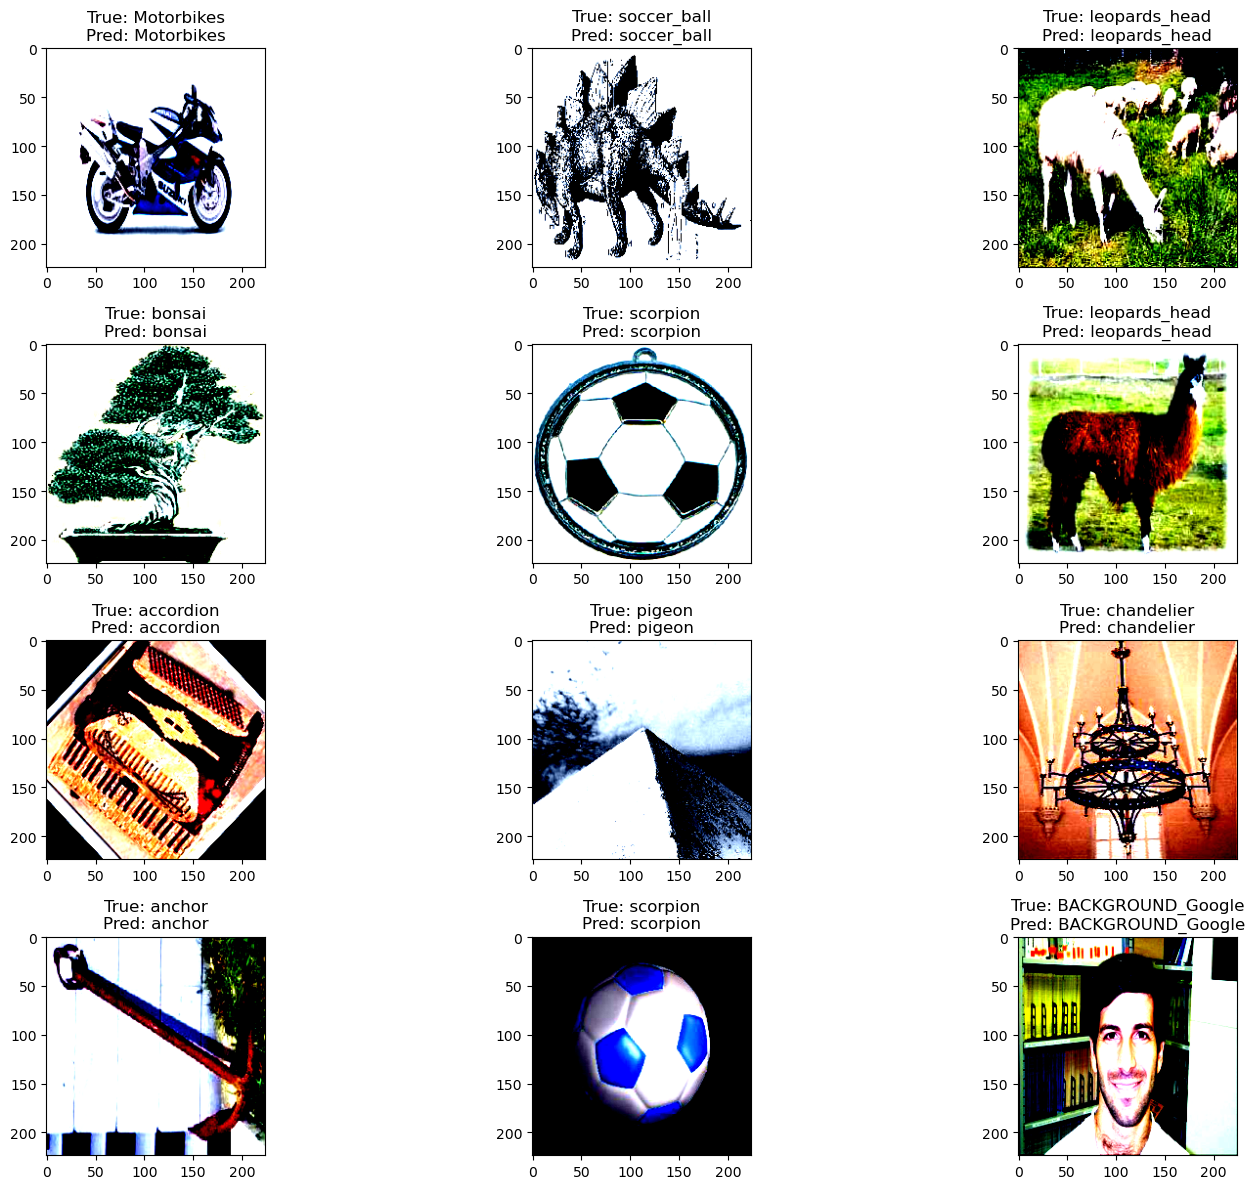

In [258]:

ROW = 4
COL = 3

fig, axs = plt.subplots(nrows = ROW , ncols = COL, figsize=(ROW*4, COL*4))

for cnt in range(ROW*COL):
    i = random.randrange(0,len(test_dataset))
    img = test_dataset[i][0]
    label = class_names[test_dataset[i][1]]
    
    #Get predicted label
    with torch.no_grad():
        #Use Model
        img, _  = test_dataset[i]
        img = img.to(device)
        outputs = resnet(img.unsqueeze(0))
        
        #Get the predicted class labels for each images
        _ , pred_num = torch.max(outputs.data , dim = 1)
        
        pred_label = class_names[pred_num]
        
    axs[(cnt) // COL, (cnt) % COL].imshow(img.cpu().permute(1, 2, 0))
    axs[cnt // COL, cnt % COL].set_title(f"True: {label}\nPred: {pred_label}")
    
plt.tight_layout()
plt.show()


### 3/10 1400i
I was wondering should I change all the image size or not.  
I chose do to so.  
I noticed that there is an error about the shape of the data. The error was saying it was 1 channel, but it has to be three.  
I didnt understand at that point because all of the images are in color. And after wasting a lot of time I went to the image and checked all the images, and I noticed that some of the images are black and white.  
The VScode was right the hole time!. Of couse. So I added lines that changes grayscale images to RGB.


### 3/11 1500i
I noticed that my acc was not going above 20% so I chagned the optimizer.  
And that change made the acc about 50% and it didnt go up from there.  
I notice that this was wrong and started to search the main reason for this.  
And I found this site "https://debuggercafe.com/getting-95-accuracy-on-the-caltech101-dataset-using-deep-learning/". This site helps me a lot.  
I noticed that I have to learn a lot of things.  
1. cv2 
2. np image  
3. one hot encoding  

I hope I can finish this soon.  
###  3/12 0106i
I fixed it! So I didnt learn all of that above (will will next time) But I used ResNet34. The acc pumped up to 90% and higher.  
I was working on the image view. There are some issues yet. I have to sleep now, its I will finish it after sleep.  
### 3/12 1126i  
Finally solved that issue. I had some issue with the ROW and COL in the images, but I solved it by calculating numbers on a paper.  
The some words in the class in not right. But I cant find the right class order. Im just going to leave it.  
Now, after organizing the code, I will have upload it to github.   
